In [548]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from scipy import stats
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import RobustScaler

df = pd.read_csv('Data/train.csv')
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


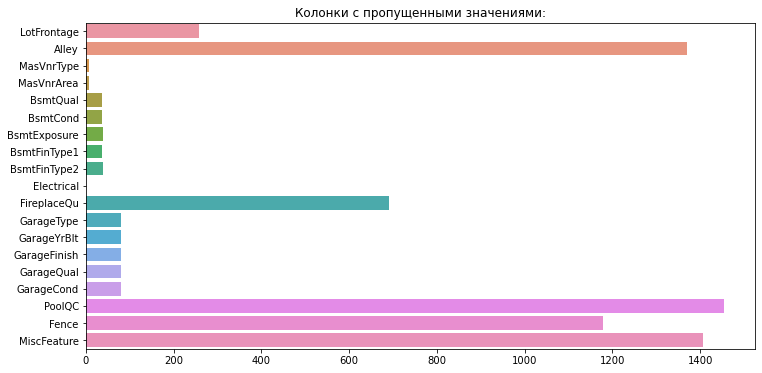

In [549]:
plt.figure(figsize=(12,6))
a = sns.barplot(y = df.isna().sum()[df.isna().sum() > 0].index, x = df.isna().sum()[df.isna().sum() > 0].values,).set_title('Колонки с пропущенными значениями:')

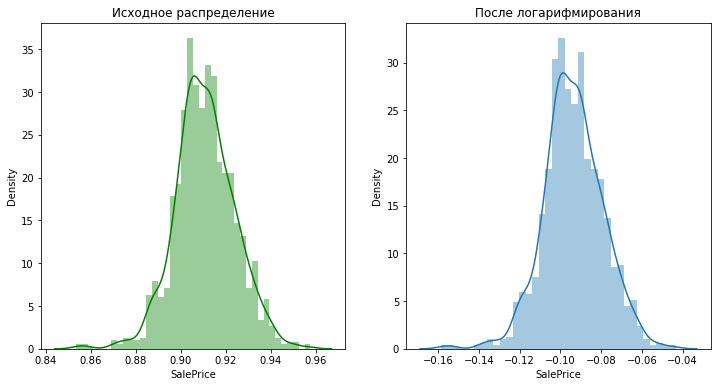

In [550]:
fig, axar = plt.subplots(1, 2, figsize = (12,6))
a = sns.distplot(y, bins = 40, color='g', ax = axar[0]).set_title('Исходное распределение')
b = sns.distplot(np.log(y), ax = axar[1]).set_title('После логарифмирования')

***Визуально распределение целевой переменной отличается от нормального, выполним логарифмирование***

In [551]:
df.drop(columns=['Id'], inplace=True)
quantitative = list(df.dtypes[(df.dtypes.values  == 'float64') | (df.dtypes.values == 'int64')].index)
qualitative = df.dtypes[(df.dtypes.values  != 'float64') & (df.dtypes.values != 'int64')].index

Отберем категориальные/вещественные переменные

In [552]:
quantitative.pop()

'SalePrice'

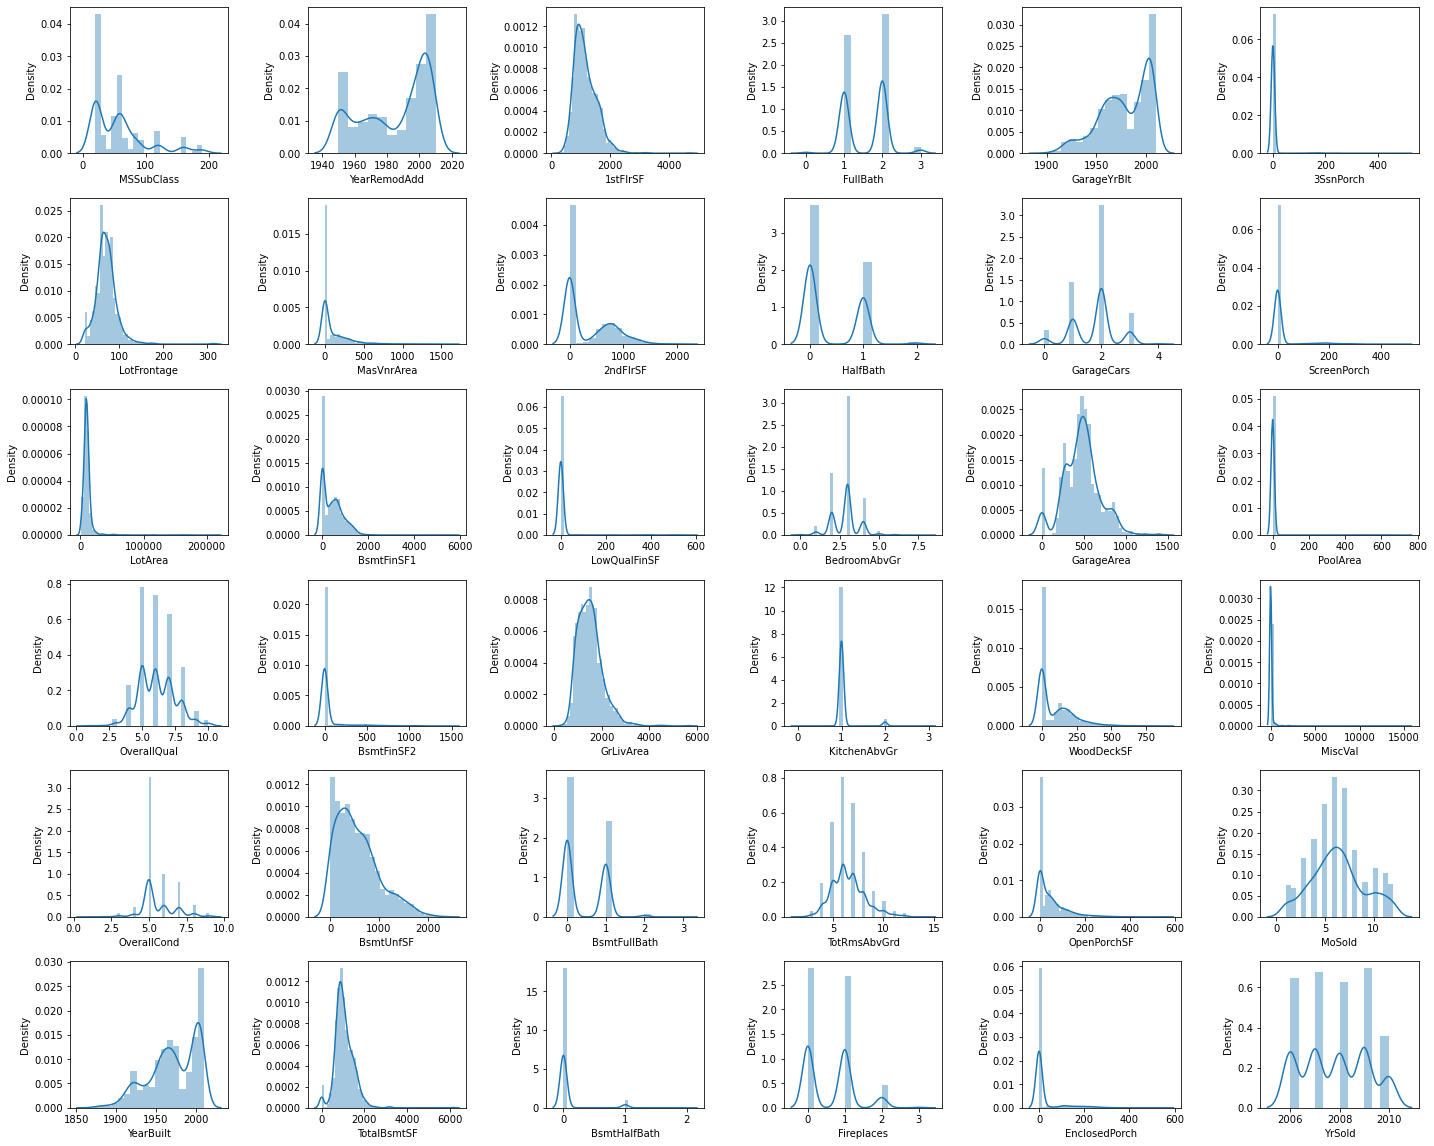

In [553]:
fig, ax = plt.subplots(6,6, figsize=(20,16))
for index, feature in enumerate(quantitative):
    sns.distplot(df[feature], ax = ax[int(index % 6), int(index / 6) ])
fig.tight_layout(pad=1.0)

Данные колонки имеют преимущественно одно значение, в последствии удалим их: BsmtFinSF2 , LowQualFinSF , EnclosedPorch , 3SsnPorch , ScreenPorch , PoolArea ,MiscVal.

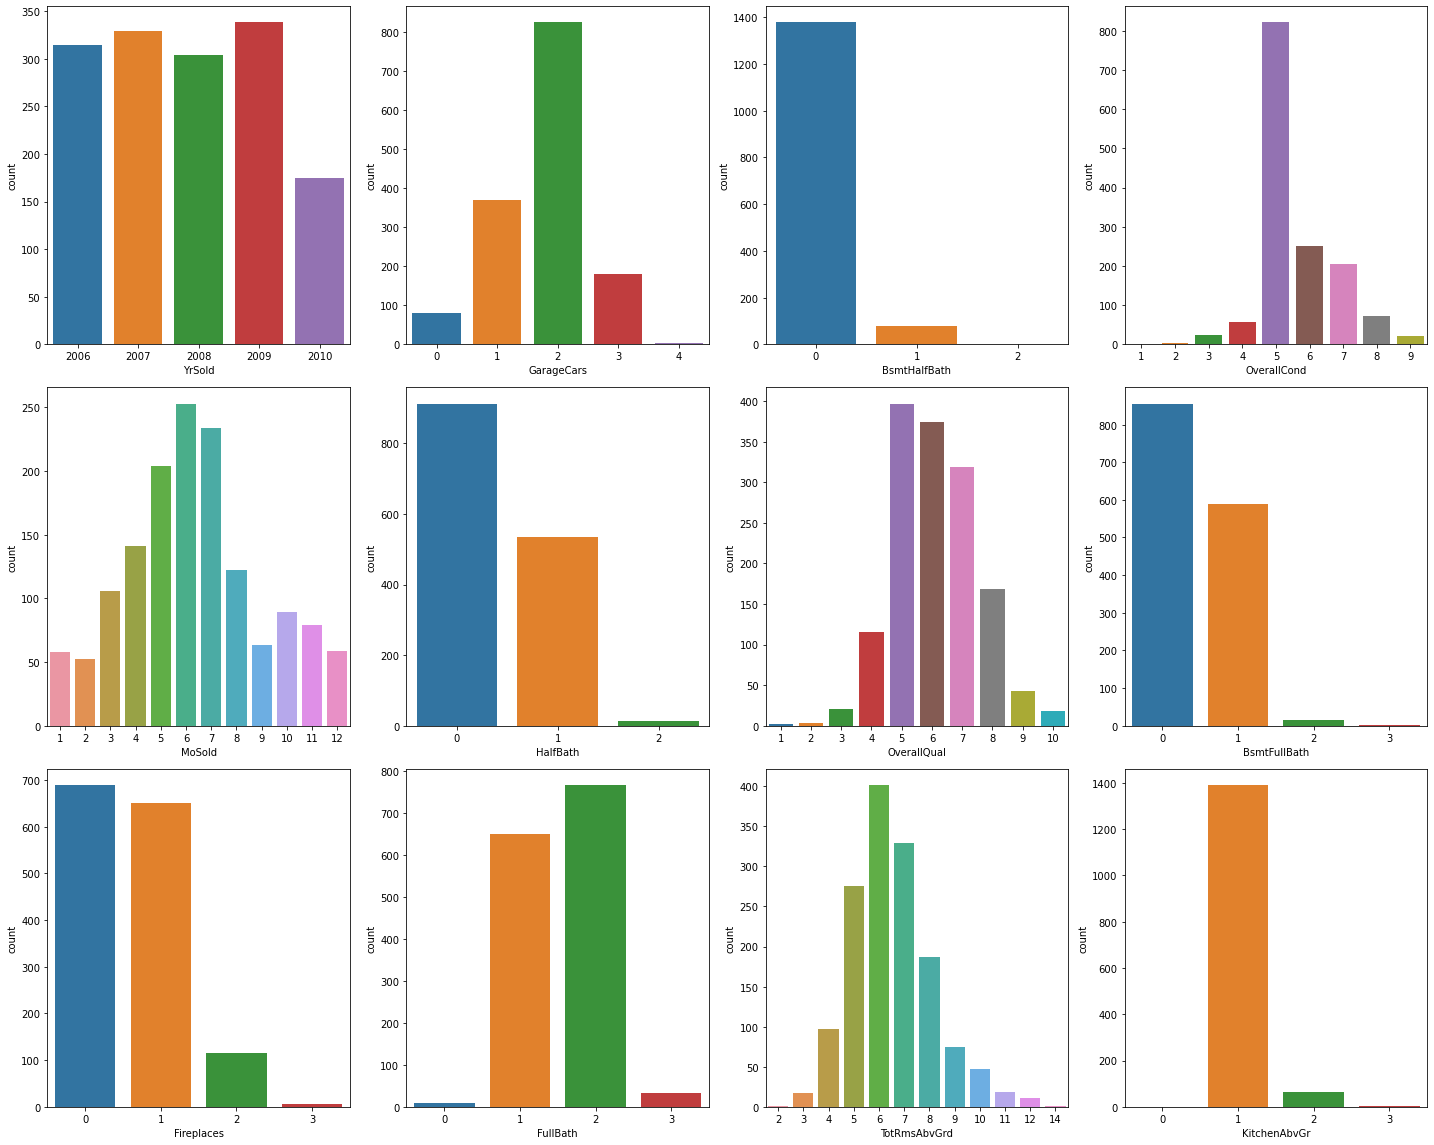

In [554]:
discrete = ['YrSold', 'MoSold','Fireplaces','GarageCars', 'HalfBath', 'FullBath', 'BsmtHalfBath','OverallQual', 'TotRmsAbvGrd', 'OverallCond','BsmtFullBath', 'KitchenAbvGr']
fig, ax = plt.subplots(3,4, figsize=(20,16))
for index, feature in enumerate(discrete):
    sns.countplot(df[feature], ax = ax[int(index % 3), int(index / 3) ])
fig.tight_layout(pad=1.0)

In [555]:
df[qualitative].isna().sum()[df[qualitative].isna().sum() > 500].index

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

***Уберем колонки с большим числом пропущенных значений***

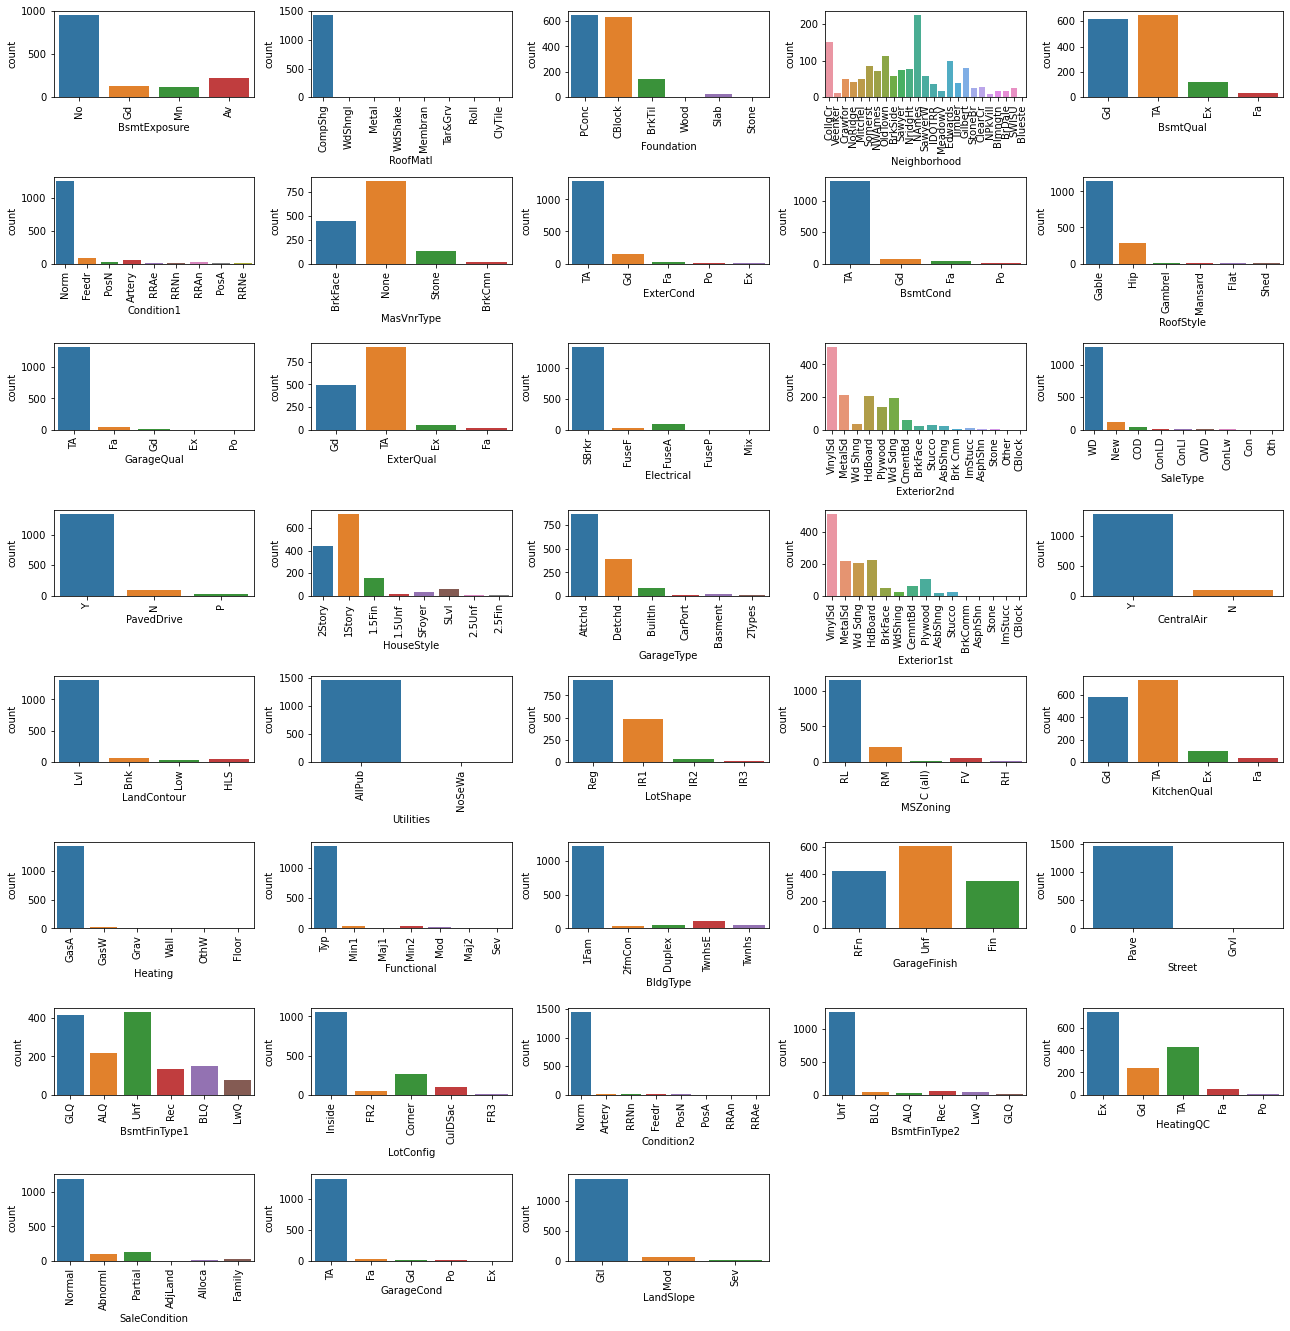

In [556]:
cat_columns = list(set(qualitative) - set(df[qualitative].isna().sum()[df[qualitative].isna().sum() > 500].index))
fig = plt.figure(figsize=(18, 20))
for index, feature in enumerate(df[cat_columns]):
    plt.subplot(9,5,index+1)
    sns.countplot(x=df[feature], data=df[cat_columns].dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

Анализ категориальных признаков

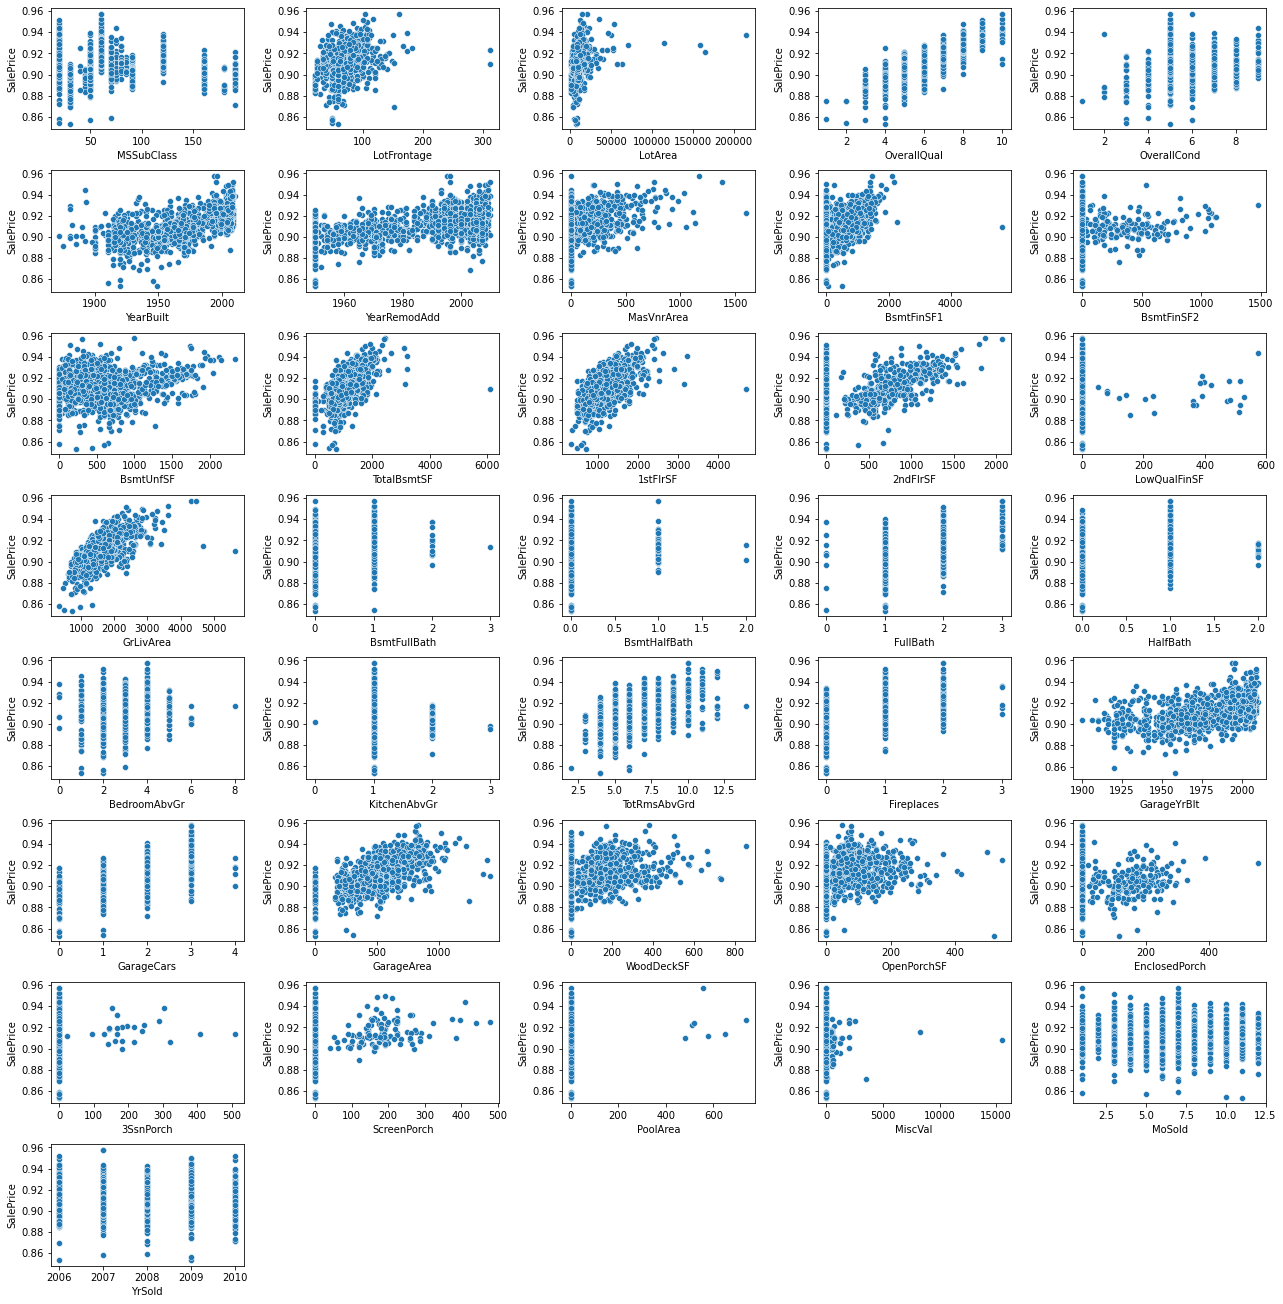

In [557]:
fig = plt.figure(figsize=(18, 20))
for index, feature in enumerate(df[quantitative]):
    plt.subplot(9,5,index+1)
    sns.scatterplot(x=df[feature], y = y, data=df[quantitative].dropna())   
fig.tight_layout(pad=1.0)

**Можно отметить наличие у некоторых признаков линейной зависимости с SalePrice, пристуствуют так же пары с зависимостью, похожей на экспоненциальную**

In [558]:
df.corr()['SalePrice'].sort_values(ascending=False).head(5)

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

In [559]:
# plt.figure(figsize=(14,12))
# corr = df[quantitative].corr()
# sns.heatmap(corr, mask = corr < 0.65, linewidth=0.5, cmap='Blues')

***Так же пристствуют линейно связанные переменные - необходимо это учесть, в т.ч. для борьбы с мультиколлинеарностью***

In [560]:
df.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars','SalePrice'], axis=1, inplace=True)

<AxesSubplot:xlabel='MoSold', ylabel='SalePrice'>

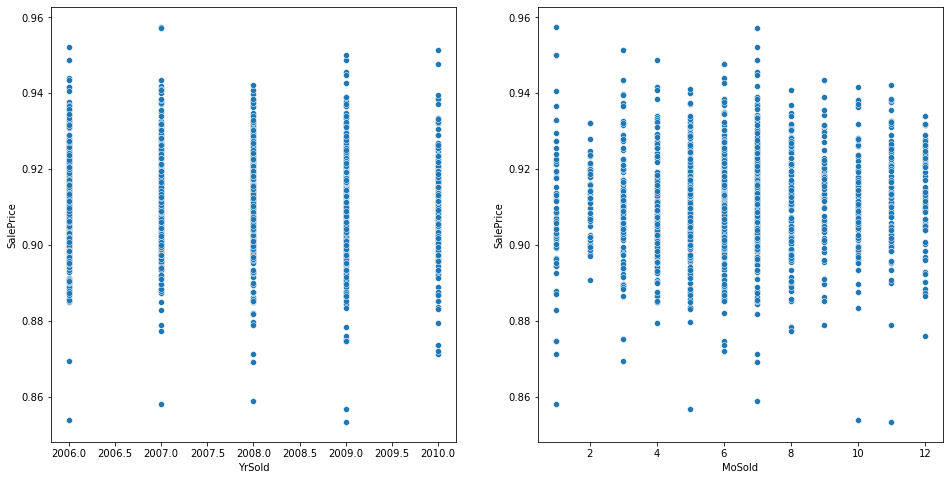

In [561]:
gif, ax = plt.subplots(1, 2, figsize=(16,8))
sns.scatterplot(x='YrSold', y = y, data=df,ax=ax[0])
sns.scatterplot(x='MoSold', y = y, data=df,ax=ax[1])

In [562]:
df.drop(['MoSold','YrSold'], axis=1, inplace=True)

Попробуем удалить признаки, имеющие в большинстве только 1 значение

In [563]:
def get_frequency(feature):
    if df[feature].value_counts().apply(lambda x:  x / df.shape[0]).head(1).values > 0.96:
        l_features.append(feature)

In [564]:
df.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

In [565]:
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']
cols = ["MasVnrType", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "Functional"]
df[cat] = df[cat].fillna("NA")
df[cols] = df.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda df: df.fillna(df.mean()))
df['GarageArea'] = df.groupby('Neighborhood')['GarageArea'].transform(lambda df: df.fillna(df.mean()))
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda df: df.fillna(df.mode()[0]))
#numerical
cont = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea"]
df[cont] = df[cont] = df[cont].fillna(df[cont].mean())
df['MSSubClass'] = df['MSSubClass'].apply(str)

Некоторые признаки имеют текстовую оценку качества, состояния какого-либо имущества и т.д. Необходимо привести их к численному виду.

In [566]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
fin_col = ['BsmtFinType1','BsmtFinType2']
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [567]:
df[ord_col] = df[ord_col].apply(lambda x: x.map(ordinal_map))
df[fin_col] = df[fin_col].apply(lambda x: x.map(fintype_map))
df['BsmtExposure'] = df['BsmtExposure'].map(expose_map)
df['Fence'] = df['Fence'].map(fence_map)

In [568]:
df['TotalLot'] = df['LotFrontage'] + df['LotArea']
df['TotalBsmtFin'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalSF'] = df['TotalBsmtSF'] + df['2ndFlrSF']
df['TotalBath'] = df['FullBath'] + df['HalfBath']
df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch']
column_bin = ['MasVnrArea','TotalBsmtFin','TotalBsmtSF','2ndFlrSF','WoodDeckSF','TotalPorch']

Добавим бинаризированные признаки, обозначающие наличие/отсутствие фичи

In [569]:
for column in column_bin:
    bin_name = column + '_bin'
    df[bin_name] = df[column].apply(lambda x: 1 if x > 0 else 0)
y = np.log(y)

In [570]:
df = pd.get_dummies(df)

In [571]:
cols = df.select_dtypes(np.number).columns
transformer = RobustScaler().fit(df[cols])
df[cols] = transformer.transform(df[cols])

Вся предобработка с последующим обучением в main/pipeline